# Model Interpretation for Pretrained Deep Learning Models

This notebook demonstrates how to apply model interpretability algorithms on pretrained deep learning models (ResNet, VGG) using a handpicked image and visualizes the attributions for each pixel by overlaying them on the image.

The interpretation algorithm that we use in this notebook is `LRP`. A noise tunnel allows to smoothen the attributions after adding gaussian noise to each input sample.

 **Installation & Library Imports**

In [1]:
!pip install -q captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms


from captum.attr import LRP
from captum.attr import visualization as viz
from captum.attr._utils.lrp_rules import EpsilonRule, GammaRule, Alpha1_Beta0_Rule

## 1- Loading the model and the dataset


Loads pretrained Resnet model and sets it to eval mode

In [3]:
model = models.resnet18(pretrained=True)
model = model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 62.1MB/s]


Downloads the list of classes/labels for ImageNet dataset and reads them into the memory

In [4]:
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2025-02-12 15:05:28--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.41.88, 52.216.106.93, 16.182.69.112, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.41.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘/root/.torch/models/imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.02s   

2025-02-12 15:05:28 (1.86 MB/s) - ‘/root/.torch/models/imagenet_class_index.json’ saved [35363/35363]



In [5]:
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

Defines transformers and normalizing functions for the image.
It also loads an image from the `img/resnet/` folder that will be used for interpretation purposes.

In [6]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

img = Image.open('/content/swan-3299528_1280.jpg')

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

Predict the class of the input image

In [7]:
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')


Predicted: goose ( 0.455486536026001 )


 ## 4- LRP-based attribution

Now let's try Layer-Wise Relevance Propagation (LRP). It uses a backward propagation mechanism applied sequentially to
all layers of the model, to see which neurons contributed to the output. The output score of LRP represents the relevance, decomposed into values for each layer.
The decomposition is defined by rules that may vary for each layer.

Initially, we apply a direct implementation of LRP attribution. The default Epsilon-Rule is used for each layer.

Note: We use the VGG16 model instead here since the default rules for LRP are not fine-tuned for ResNet currently.

In [8]:
model = models.vgg16(pretrained=True)
model.eval()
lrp = LRP(model)

attributions_lrp = lrp.attribute(input,
                                target=pred_label_idx)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 64.0MB/s]
/usr/local/lib/python3.11/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Let us visualize the attribution, focusing on the areas with positive attribution (those that are critical for the classifier's decision):

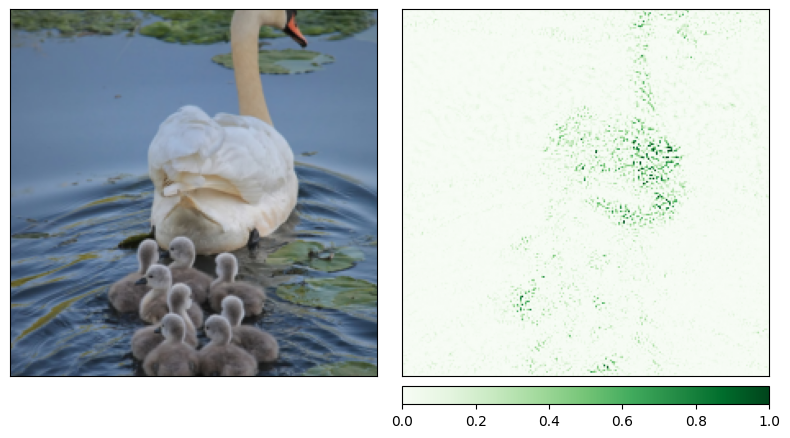

In [9]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_lrp.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)

Now let's play around with changing the propagation rules for the various layers. This is a crucial step to get expressive heatmaps. Captum currently has the following propagation rules implemented: LRP-Epsilon, LRP-0, LRP-Gamma, LRP-Alpha-Beta, and the Identity-Rule.

In the next steps, we list all the layers of VGG16 and assign a rule to each one.

Note: Reference for recommmendations on how to set the rules can be found in *[Towards best practice in explaining neural network decisions with LRP](https://arxiv.org/abs/1910.09840)*.

In [10]:
layers = list(model._modules["features"]) + list(model._modules["classifier"])
num_layers = len(layers)

for idx_layer in range(1, num_layers):
    if idx_layer <= 16:
        setattr(layers[idx_layer], "rule", GammaRule())
    elif 17 <= idx_layer <= 30:
        setattr(layers[idx_layer], "rule", EpsilonRule())
    elif idx_layer >= 31:
        setattr(layers[idx_layer], "rule", EpsilonRule(epsilon=0))

lrp = LRP(model)
attributions_lrp = lrp.attribute(input,
                                target=pred_label_idx)

/usr/local/lib/python3.11/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Let us visualize the new attribution. As we can see in the generated output image, the heatmap shows clearly positive attributions forthe beak of the swan.

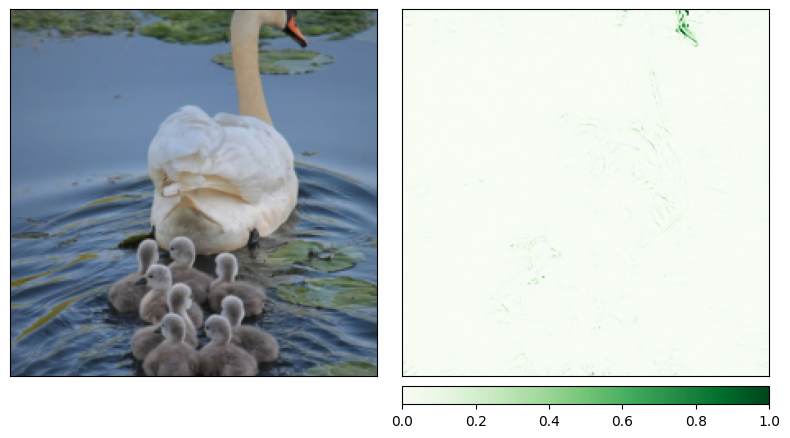

In [11]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_lrp.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)